In [ ]:
import torch
from torch import nn
from torchvision.datasets import FashionMNIST
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss, NLLLoss, MSELoss
from torch.optim.lr_scheduler import StepLR
import math
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Normalize, Compose

In [122]:
# Hyper-parameter
epochs = 20
batch_size = 256

In [123]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [124]:
transform = Compose([ToTensor(), Normalize(0, 1)])

In [ ]:
train_data = FashionMNIST('data', train=True, transform=transform, download=True)
test_data = FashionMNIST('data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=batch_size, pin_memory=True, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, pin_memory=True, shuffle=False)

In [ ]:
class Module(nn.Module):
    def __init__(self):
        super(Module, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 6, (5, 5), padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d(2, 2),
            
            nn.Conv2d(6, 16, (5, 5)),
            nn.Sigmoid(),
            nn.AvgPool2d(2, 2),
            
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.Sigmoid(),
            
            nn.LazyLinear(84),
            nn.Sigmoid(),
            
            nn.LazyLinear(10),
            nn.LogSoftmax(1),
        )
    def forward(self, X):
        return self.net(X)

In [ ]:
model = Module(); model.to(device)
optimizer = Adam(model.parameters(), 0.001)
loss = NLLLoss()
scheduler = StepLR(optimizer, 10, math.exp(-0.1))

In [128]:
from torchsummary import summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
           Sigmoid-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
           Sigmoid-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 120]          48,120
           Sigmoid-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
          Sigmoid-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
             ReLU-13                   [-1, 10]               0
Total params: 61,706
Trainable params: 

In [129]:
history = {
    'acc':[],
    'loss':[],
    'val_acc':[],
    'val_loss':[]
}

In [ ]:
for i in range(epochs):
    print('\033[33m' + f'Epoch {i + 1} Start' + '\33[0m')
    
    # Start Training
    train_acc = 0
    train_loss = 0
    
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        img, label = data
        img, label = img.to(device), label.to(device).float()
        
        output = model(img)
        output_loss = loss(output, label)
        # Calculate
        train_acc += (output.argmax(dim=1) == label).sum().item()
        train_loss += output_loss.item()
        # BP
        output_loss.backward()
        optimizer.step()
    # scheduler.step()
    train_acc = train_acc / len(train_data)
    train_loss /= len(train_loader)
    
    # Start Valuation
    test_acc = 0
    test_loss = 0
    
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            img, label = data
            img, label = img.to(device), label.to(device).float()
            
            output = model(img)
            output_loss = loss(output, label)
            # Calculate
            test_acc += (output.argmax(dim=1) == label).sum().item()
            test_loss += output_loss.item()
    test_acc = test_acc / len(test_data)
    test_loss /= len(test_loader)
    
    history['acc'].append(train_acc)
    history['loss'].append(train_loss)
    history['val_acc'].append(test_acc)
    history['val_loss'].append(test_loss)
    
    print(f'Train acc: {train_acc:.4f}, loss: {train_loss:.4f}')
    print(f'Test acc: {test_acc:.4f}, loss: {test_loss:.4f}')
    print('======================================')

Epoch 1 Start
Train acc: 0.1058, loss: 0.0967
Test acc: 0.1135, loss: 0.0950
Epoch 2 Start
Train acc: 0.1098, loss: 0.0949
Test acc: 0.1775, loss: 0.0948
Epoch 3 Start
Train acc: 0.3724, loss: 0.0763
Test acc: 0.5806, loss: 0.0551
Epoch 4 Start
Train acc: 0.6569, loss: 0.0462
Test acc: 0.7032, loss: 0.0409
Epoch 5 Start
Train acc: 0.7137, loss: 0.0398
Test acc: 0.7244, loss: 0.0381
Epoch 6 Start
Train acc: 0.7339, loss: 0.0378
Test acc: 0.7374, loss: 0.0369
Epoch 7 Start
Train acc: 0.7459, loss: 0.0365
Test acc: 0.7537, loss: 0.0355
Epoch 8 Start
Train acc: 0.7544, loss: 0.0355
Test acc: 0.7597, loss: 0.0347
Epoch 9 Start
Train acc: 0.7612, loss: 0.0348
Test acc: 0.7638, loss: 0.0341
Epoch 10 Start
Train acc: 0.7659, loss: 0.0343
Test acc: 0.7652, loss: 0.0340
Epoch 11 Start
Train acc: 0.7699, loss: 0.0338
Test acc: 0.7748, loss: 0.0336
Epoch 12 Start
Train acc: 0.7730, loss: 0.0335
Test acc: 0.7737, loss: 0.0331
Epoch 13 Start
Train acc: 0.7752, loss: 0.0332
Test acc: 0.7733, loss: 0.

In [ ]:
print('best val acc', round(max(history['val_acc']), 4))

In [131]:
def show(history:dict, name):
    plt.cla(); plt.clf()
    plt.plot(history[name], 'b', label='train')
    plt.plot(history['val_'+name], 'r', label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()
    plt.title('Performance')
    plt.show()

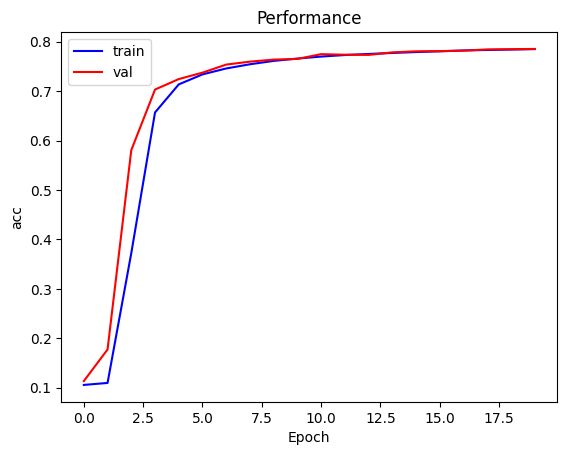

In [132]:
show(history, 'acc')

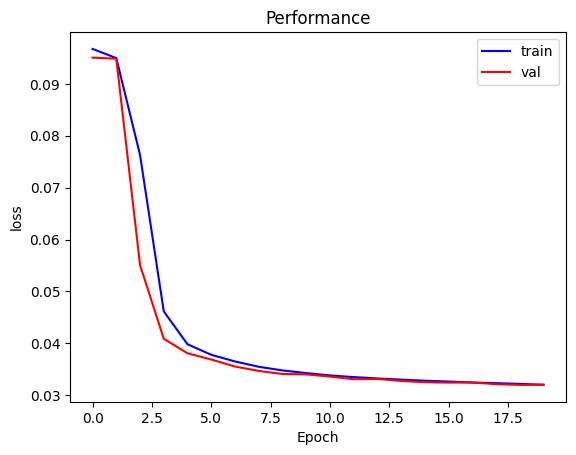

In [133]:
show(history, 'loss')